# Generative Adversarial Networks (GANs)

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# This part is necessary, otherwise when a matplotlib command is executed a 'kernel died' error is taken and execution stops.
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import torch

from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader

from torch.optim import Adam

torch.manual_seed(0) # Set for testing purposes, please do not change!

from tqdm.auto import tqdm

In [2]:
def show_training_output(generated_image_tensor, real_image_tensor, num_images=25, size=(1, 28, 28)):
    
    image_unflat = generated_image_tensor.detach().cpu().view(-1, *size)
    image_grid_generated = make_grid(image_unflat[:num_images], nrow=5)
    
    image_unflat = real_image_tensor.detach().cpu().view(-1, *size)
    image_grid_real = make_grid(image_unflat[:num_images], nrow=5)
    
    
    fig, axes = plt.subplots(1,2, figsize=(5,2))
    axes[0].imshow(image_grid_generated.permute(1, 2, 0).squeeze())
    axes[1].imshow(image_grid_real.permute(1, 2, 0).squeeze())
    axes[0].title.set_text('Generated')
    axes[1].title.set_text('Real')
    plt.show()

## Load MNIST Data

In [3]:
batch_size = 128

#Load MNIST dataset as tensors
MNIST_loader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()),
                          batch_size=batch_size, shuffle=True)

It is always good to know what we are working with so a subset of the MNIST data will be shown here.

Image shape torch.Size([1, 28, 28])


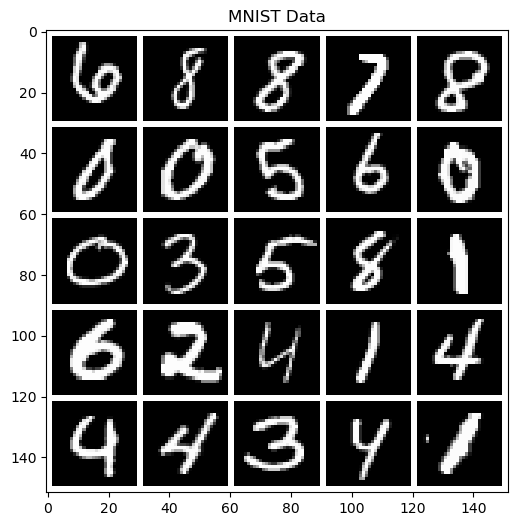

In [4]:
num_imgs_to_visualize = 25  # number of images we'll display
batch = next(iter(MNIST_loader))  # take a single batch from the dataset
img_batch = batch[0]  # extract only images and ignore the labels (batch[1])
img_batch_subset = img_batch[:num_imgs_to_visualize]  # extract only a subset of images

print(f'Image shape {img_batch_subset.shape[1:]}')  # we ignore shape[0] - number of imgs in batch.

grid = make_grid(img_batch_subset, nrow=int(np.sqrt(num_imgs_to_visualize)), normalize=True, pad_value=1.)
grid = np.moveaxis(grid.numpy(), 0, 2)  # from CHW -> HWC format that's what matplotlib expects! Get used to this.

plt.figure(figsize=(6, 6))
plt.imshow(grid)
plt.title("MNIST Data")
plt.show()


## Generator Network

In [5]:
def gen_block(dim_in, dim_out):
    block=nn.Sequential(nn.Linear(dim_in, dim_out),
                        nn.BatchNorm1d(dim_out),
                        nn.ReLU(inplace=True))
    
    return block

In [6]:
class GeneratorNetwork(nn.Module):

    def __init__(self, noise_dim=10, im_dim=784, hidden_dim=128):
        super(GeneratorNetwork, self).__init__()
        
        self.gen = nn.Sequential(gen_block(noise_dim, 256),
                                 gen_block(256, 512),
                                 gen_block(512, 1024),
                                 
                                 nn.Linear(1024, im_dim),
                                 nn.Sigmoid())
    def forward(self, noise):
        
        return self.gen(noise)

In [7]:
def get_latent_vector(n_samples, dim_latent, device='cpu'):
    
    return torch.randn(n_samples, dim_latent, device=device)

## Discriminator Network

Discriminator is nothing more than a neural network doing binary classification (1 for real images and 0 for fake images). Here a little trial-error is necessary to find best option. In this project a 4-stage neural network has been implemented. Note that there is no sigmoid at the end since the loss used (i.e. nn.BCEWithLogitsLoss) already has this sigmoid functionality in itself.

In [8]:
def disc_block(dim_in, dim_out):
    block=nn.Sequential(nn.Linear(dim_in, dim_out),
                        nn.LeakyReLU(negative_slope=0.2))
    return block

In [9]:
class DiscriminatorNetwork(nn.Module):
    def __init__(self, im_dim=784, hidden_dim=128):
        super(DiscriminatorNetwork, self).__init__()
        
        self.disc = nn.Sequential(disc_block(im_dim, 512),
                                  disc_block(512, 256),
                                  disc_block(256, 128),
                                  disc_block(128, 64),
                                  
                                  nn.Linear(64, 1))

    def forward(self, image):
        
        return self.disc(image)

## Training the Model (Optional)

The below cell executes the actual training part. Its output is removed from the notebook since it takes much space here and also the file size gets unnecessarily large but anyone interested can simply run the cell. Otherwise, this part can be skipped and the existing model file can be run in the latter part.

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0

no_epochs = 200
dim_latent = 100
show_every = 500

# Add GPU as processing device if available, otherwise CPU.
if torch.cuda.is_available() == True:
    proc_dev = 'cuda'
else:
    proc_dev = 'cpu'

adv_loss = nn.BCEWithLogitsLoss() #adversarial loss

lr = 0.0001
gen = GeneratorNetwork(dim_latent).to(proc_dev)
gen_opt = Adam(gen.parameters(), lr=lr)
disc = DiscriminatorNetwork().to(proc_dev) 
disc_opt = Adam(disc.parameters(), lr=lr)

for epoch in range(no_epochs):
    
    print('Epoch: ', epoch+1, '/',no_epochs)
  
    # Dataloader returns the batches
    for real, _ in tqdm(MNIST_loader):
        cur_batch_size = len(real)

        # Flatten the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(proc_dev)
        
        # Train discriminator network.
        disc_opt.zero_grad()
        
        generated_images = gen(get_latent_vector(cur_batch_size, dim_latent, device=proc_dev))
        generated_images_predictions = disc(generated_images.detach())
        generated_discriminator_loss = adv_loss(generated_images_predictions, torch.zeros_like(generated_images_predictions))
        real_discriminator_loss = adv_loss(disc(real), torch.ones_like(disc(real)))
        disc_loss = 1/2*(real_discriminator_loss + generated_discriminator_loss)
        
        disc_loss.backward(retain_graph=True)
        disc_opt.step()
        
        # Train generator network.
        gen_opt.zero_grad()
        
        gen_pred = disc(gen(get_latent_vector(cur_batch_size, dim_latent, device=proc_dev)))
        gen_loss = adv_loss(gen_pred, torch.ones_like(gen_pred))
        
        gen_loss.backward(retain_graph=True)
        gen_opt.step()


        mean_discriminator_loss += disc_loss.item() / show_every
        mean_generator_loss += gen_loss.item() / show_every
        
        if cur_step % show_every == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            latent_vector = get_latent_vector(cur_batch_size, dim_latent, device=proc_dev)
            generated = gen(latent_vector)
            show_training_output(generated, real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
                
        cur_step += 1
        

In [11]:
model_path = os.path.join(os.getcwd(), 'models') 

if not os.path.exists(model_path):
    os.makedirs(model_path)

torch.save(gen, os.path.join(model_path, 'GAN_model.pth'))

## Model Output

The model output can be observed here for any random input.

In [14]:
gen_loaded = torch.load(os.path.join(os.getcwd(), 'models', 'GAN_model.pth'))

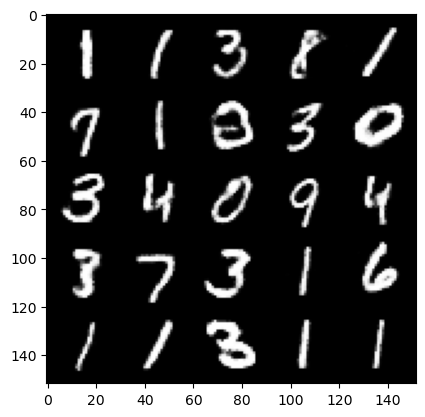

In [17]:
latent_vector = get_latent_vector(cur_batch_size, dim_latent, device=proc_dev)
generated_digits = gen_loaded(latent_vector)

image_size=(1, 28, 28)
image_unflat = generated_digits.detach().cpu().view(-1, *image_size)
image_grid = make_grid(image_unflat[:25], nrow=5)

plt.figure()
plt.imshow(image_grid.permute(1, 2, 0).squeeze())
plt.show()